In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ftplib import FTP
import datetime
import re
import zipfile
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # set default size of plots

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('Set2', 10)

# Get the data
Start by making an FTP connection and retrieve the gtfs zip file's modification date. We're restricted from using most commands, but we can LIST...

In [3]:
MOT_FTP = 'gtfs.mot.gov.il'
FILE_NAME = 'israel-public-transportation.zip'
UPTODATE = 150 #days
local_zip_path = 'data/sample/gtfs.zip' 

conn = FTP(MOT_FTP)
conn.login()
ftp_dir = []
conn.retrlines('LIST', lambda x: ftp_dir.append(x)) 
ftp_dir

['11-18-13  03:20PM       <DIR>          aspnet_client',
 '04-03-18  12:21AM                24200 ClusterToLine.zip',
 '04-03-18  12:21AM            224714230 israel-public-transportation.zip',
 '04-03-18  12:21AM               100433 Tariff.zip',
 '04-03-18  12:21AM                30795 TrainOfficeLineId.zip',
 '04-03-18  12:21AM              8636847 TripIdToDate.zip',
 '12-20-17  05:37PM                53105 zones.zip']

Now that we have a list of file records, lets extract the dates and see if our file is up-to-date

In [4]:
RE_FTP_LINE = re.compile(
    r'(?P<date>\d+-\d+-\d+\s+\d+:\d+[APM]{2})\s+(?P<size><DIR>|[0-9]+)\s+(?P<file_name>.*)')
f = [re.findall(RE_FTP_LINE, line) for line in ftp_dir]
f_dates = {t[0][2]: datetime.datetime.strptime(t[0][0], "%m-%d-%y  %H:%M%p") for t in f}

ftp_date = f_dates[FILE_NAME]

have_zip = os.path.exists(local_zip_path)
if have_zip:
    our_date = datetime.datetime.fromtimestamp(os.path.getmtime(local_zip_path))

    our_uptodateness = (ftp_date - our_date).days
    print(f'Our zip is {our_uptodateness} days old')
    if our_uptodateness > UPTODATE:
        print('Oh snap we need to download a new zip...')
    else:
        print('Oh goody! we\'re up-to-date!')


Our zip is 37 days old
Oh goody! we're up-to-date!


And now we shall actually download the zip... if we really want to...

In [5]:
if (have_zip and our_uptodateness > UPTODATE) or not have_zip:
    temp_local_path = 'data/sample/gtfs_temp.zip'
    fh = open(temp_local_path, 'wb')
    conn.retrbinary('RETR %s' % (FILE_NAME), fh.write)
    fh.close()
    #TODO THIS DOESN'T WORK IF YOU DIDN"T HAVE FILE
    os.remove(local_zip_path)
    os.rename(temp_local_path, local_zip_path)

conn.quit()
    

'221 Goodbye.'

Lets also load MOT's tarrif.txt file, which will give us zone names and other local info

In [7]:
TARIFF_FILE_NAME = 'Tariff.zip'
TARIFF_TXT_NAME = 'Tariff.txt'
TARIFF_TO_REFORM_ZONE = 'StationToReformZone.txt'
local_tariff_path = 'data/sample/tariff.zip' 

conn = FTP(MOT_FTP)
conn.login()
fh = open(local_tariff_path, 'wb')
conn.retrbinary('RETR %s' % (TARIFF_FILE_NAME), fh.write)
fh.close()
conn.quit()

'221 Goodbye.'

# Tidy it up
One tidy dataset for stop_times, I'll use [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates. 

In [8]:
import partridge as ptg

service_ids_by_date = ptg.read_service_ids_by_date(local_zip_path)
next_thursday = None #TODO: add this instead of hardcoding the date
service_ids = service_ids_by_date[datetime.date(2018, 3, 1)]

feed = ptg.feed(local_zip_path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})


The partridge feed now references all the GTFS files in the zip, and will only load them to memory only once used

## New zone mapping

Before we build our first stop times tidy DataFrame, we need zone name data. We need to combine `Tariff.txt` with `StationToReformZone.txt` to a mapping as described in MOT's developers [pdf](https://www.gov.il/BlobFolder/generalpage/gtfs_general_transit_feed_specifications/he/%D7%A1%D7%98%20%D7%A7%D7%91%D7%A6%D7%99%D7%9D%20-%20GTFS%20-%20%D7%94%D7%A1%D7%91%D7%A8%20%D7%9C%D7%9E%D7%A4%D7%AA%D7%97%D7%99%D7%9D_0.pdf).

**Note**: I'm disregarding `FromDate` and `ToDate` and just dropping duplicates. So we will give wrong zone names for zone changes within the GTFS 60 day period.

In [43]:
# not a true csv, so we need to jiggle it a bit
cols = ['ShareCode','ShareCodeDesc','ZoneCodes','Daily','Weekly','Monthly','FromDate','ToDate', 'EXTRA']
reform_cols = ['StationId', 'ReformZoneCode','FromDate','ToDate', 'EXTRA']
with zipfile.ZipFile(local_tariff_path) as zf:
    tariff_df = (pd.read_csv(zf.open(TARIFF_TXT_NAME), header=None, skiprows=[0], names = cols)
                .drop(columns = ['EXTRA']))
    reform_df = (pd.read_csv(zf.open(TARIFF_TO_REFORM_ZONE), header=None, skiprows=[0], names = reform_cols)
                 .drop(columns = ['EXTRA']))

    
# remove ShareCodes which contain multiple zones  e.g. גוש דן מורחב
tariff_df = (tariff_df[~ tariff_df.ZoneCodes.str.contains(';')]
             .rename(columns = {'ShareCodeDesc': 'zone_name',
                               'ZoneCodes': 'zone_id'}))
tariff_df.head()

,ShareCode,zone_name,zone_id,Daily,Weekly,Monthly,FromDate,ToDate
0,141,גוש דן,210,13.5,64.0,213.0,28/03/2018 00:00:00,01/01/2200 00:00:00
10,152,שרון,221,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00
11,153,ראש העין שוהם,222,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00
12,154,רחובות,223,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00
13,155,נתניה,231,13.5,57.5,149.0,28/03/2018 00:00:00,01/01/2200 00:00:00


In [49]:
rs = reform_df[['StationId', 'ReformZoneCode']].drop_duplicates().applymap(str).set_index('StationId').iloc[:,0]
rs.head()

StationId
2716    110
2718    110
2720    110
2721    110
2747    110
Name: ReformZoneCode, dtype: object

In [50]:
ts = (tariff_df[['zone_id', 'zone_name']].drop_duplicates().set_index('zone_id').iloc[:,0])
ts.head()

zone_id
210           גוש דן
221             שרון
222    ראש העין שוהם
223           רחובות
231            נתניה
Name: zone_name, dtype: object

In [61]:
zones = rs.map(ts).reset_index().rename(columns={'StationId': 'stop_code', 'ReformZoneCode':'zone_name'})

And we're ready to build our final stop_times DataFrame. Not a lot of work on it, as it is already in a good tidy format, just select the columns we want, do some transformations and merges.

In [76]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

f = (feed.stop_times[['trip_id', 'arrival_time', 'stop_id']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'stop_code']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(zones, how='left')
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,stop_code,zone_name
0,26398526_240218,06:37:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
1,30901833_240218,06:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
2,30901838_240218,12:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
3,30901843_240218,13:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן
4,30901848_240218,14:07:00,37358,2017-12-21,תל אביב מרכז,32.083715,34.798247,17038,גוש דן


## Top 10 zones

In [98]:
top_zones = f.groupby('zone_name').size().sort_values(ascending=False).head(10)
top_zones.reset_index()

,zone_name,0
0,גוש דן,810197
1,סובב ירושלים,404926
2,סובב חיפה,310534
3,נצרת,140255
4,שרון,110185
5,באר שבע,105101
6,אשדוד,90111
7,נתניה,88064
8,חבל מודיעין,81343
9,ראש העין שוהם,73303


## Zone timeline

In [99]:
zone10 = (f[f.zone_name.isin(top_zones.index)].set_index('arrival_time')
          .groupby([pd.Grouper(freq='1T'), 'zone_name'])
          .size())
zones10 = zone10.reset_index().rename(columns={0: 'size'})
#reverse names so they will show nicely in plot
zones10 = zones10.assign(zone_name=lambda x: (x['zone_name'].str[::-1]))
zones10 = zones10.pivot('arrival_time', 'zone_name', 'size')

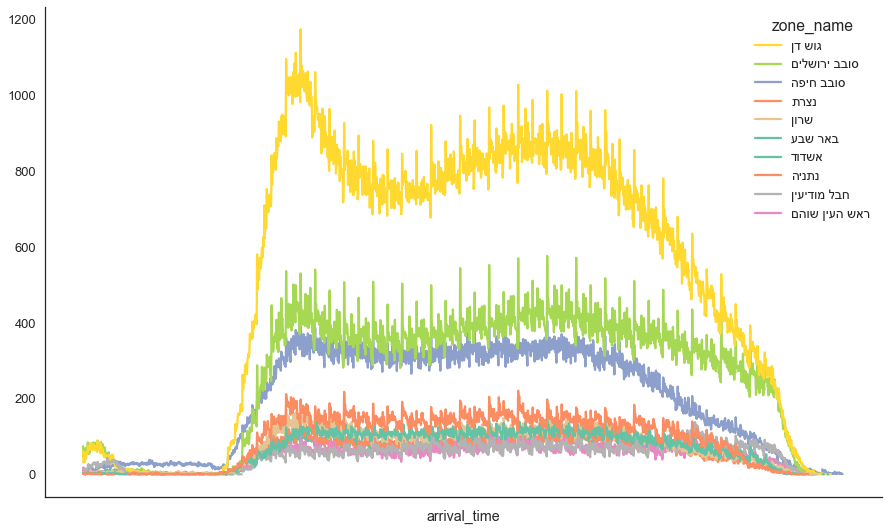

In [100]:
fig, ax = plt.subplots()
zones10.plot(figsize=(15,10), ax=ax)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by their rank (and do so in a very weird way :))
top_zones_rank = top_zones.reset_index()
labels, handles = zip(*sorted(zip(labels, handles), 
                              key=lambda t: top_zones_rank[top_zones_rank.zone_name==t[0][::-1]].index.tolist()[0]))
ax.legend(handles, labels, title="zone_name")

sns.despine()

Looking good...